In [35]:
# Import different packages 
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, Sequential, models
import time

# Import the data
from google.colab import drive
drive.mount('/content/drive')
train_dataset = tf.data.Dataset.load('/content/drive/MyDrive/assign2_train')
batch_size1=128
train_dataset_batch=train_dataset.batch(batch_size1)
val_dataset = tf.data.Dataset.load('/content/drive/MyDrive/assign2_val')
batch_size2=128
val_dataset_batch= val_dataset.batch(batch_size2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## P1-Parallel CNNs and RNNs

### P1.1 CNN

In [36]:
# structure of the dataset
print(train_dataset_batch.element_spec)
print(val_dataset_batch.element_spec)

(TensorSpec(shape=(None, 80, 80, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 80, 80, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))


In [37]:
#define the model
# Define the model architecture
def create_model(input_shape, num_classes):
  input_layer = layers.Input(shape=input_shape)

  # First parallel branch
  x1 = layers.Conv2D(3, kernel_size=8, padding='same')(input_layer)
  x1 = layers.LeakyReLU(alpha=0.3)(x1)
  x1 = layers.MaxPooling2D(pool_size=4)(x1)
  x1 = layers.Flatten()(x1)

  # Second parallel branch
  x2 = layers.Conv2D(4, kernel_size=4, padding='same')(input_layer)
  x2 = layers.LeakyReLU(alpha=0.3)(x2)
  x2 = layers.MaxPooling2D(pool_size=2)(x2)
  x2 = layers.Flatten()(x2)

  # Merge the two branches together
  merged = layers.concatenate([x1, x2])
  # choose the 'softmax' as the output layer
  output_layer = layers.Dense(num_classes, activation='softmax')(merged)
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

  return model

In [ ]:
# Define the evaluation metric and loss function,chosse the accuracy as the metric and 'categorical_crossentropy' as the loss function
metrics = ['accuracy']
loss = 'categorical_crossentropy'

# Create the model
input_shape = (80, 80, 1)
num_classes = 8
model = create_model(input_shape, num_classes)

# Compile the model with mini-batch stochastic gradient descent optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])

# Train the model for 50 epochs
epochs = 50
history = model.fit(train_dataset_batch, epochs=epochs, validation_data=val_dataset_batch)

Epoch 1/50
75/75 [==============================] - 3s 21ms/step - loss: 1.4143 - acc: 0.4827 - val_loss: 1.2418 - val_acc: 0.5229
Epoch 2/50
75/75 [==============================] - 1s 15ms/step - loss: 1.1176 - acc: 0.5872 - val_loss: 1.1261 - val_acc: 0.5713
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 1.0074 - acc: 0.6286 - val_loss: 1.0639 - val_acc: 0.6021
Epoch 4/50
75/75 [==============================] - 1s 16ms/step - loss: 0.9325 - acc: 0.6600 - val_loss: 1.0175 - val_acc: 0.6196
Epoch 5/50
75/75 [==============================] - 2s 26ms/step - loss: 0.8732 - acc: 0.6841 - val_loss: 0.9785 - val_acc: 0.6438
Epoch 6/50
75/75 [==============================] - 1s 15ms/step - loss: 0.8227 - acc: 0.7041 - val_loss: 0.9444 - val_acc: 0.6596
Epoch 7/50
75/75 [==============================] - 1s 15ms/step - loss: 0.7788 - acc: 0.7195 - val_loss: 0.9152 - val_acc: 0.6733
Epoch 8/50
75/75 [==============================] - 1s 15ms/step - loss: 0.7398 - a

Text(0.5, 0.98, 'P1-CNN Model')

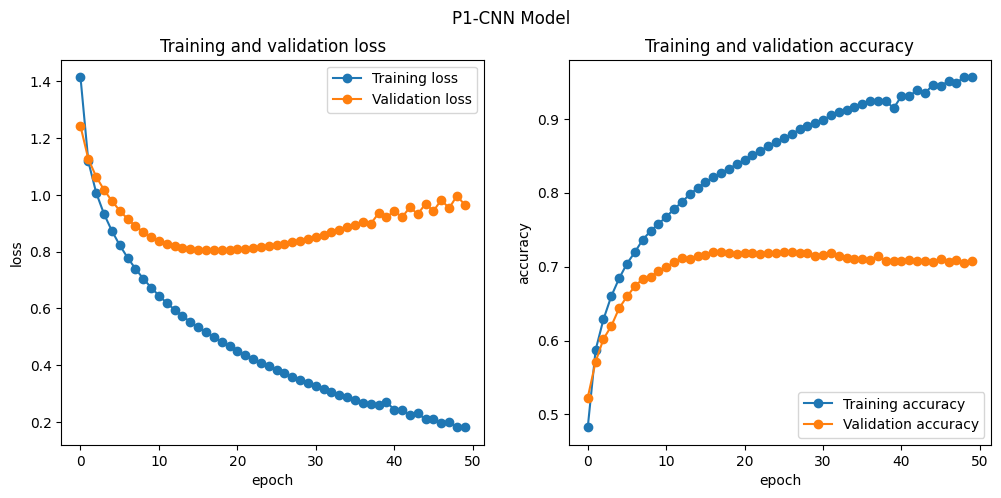

In [ ]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['loss'],'-o', label='Training loss')
ax1.plot(history.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history.history['acc'],'-o', label='Training accuracy')
ax2.plot(history.history['val_acc'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('P1-CNN Model')

In [ ]:
# evaluate test accuracy
results = model.evaluate(val_dataset_batch)
print('Validation Loss:', results[0])
print('Validation Accuracy:', results[1])

19/19 [==============================] - 0s 10ms/step - loss: 0.9646 - acc: 0.7079
Validation Loss: 0.9645674824714661
Validation Accuracy: 0.7079166769981384


### P1.2 CNN-RNN based classifier

In [ ]:
# Reduce dimensionality
def reduce_dimension(x, y):
  return tf.squeeze(x, axis=-1), y

train_dataset_squeeze = train_dataset.map(reduce_dimension)
val_dataset_squeeze = val_dataset.map(reduce_dimension)

# Batch the data
batch_size = 128
train_dataset_batch = train_dataset.batch(batch_size)
val_dataset_batch = val_dataset.batch(batch_size)

# Define CNN-RNN model
model = models.Sequential()
model.add(layers.Conv2D(8, (4, 4), activation='relu', input_shape=(80, 80, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(6, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#faltten the output of the second CNN layer, and reshape it since the CNN has 4D shape of output, but LSTM need a 3D shape of Input.
model.add(layers.Flatten())
model.add(layers.Reshape((18, 18*6)))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(8, activation='softmax'))

# Compile the model, use accuracy as the metrics and crossentropy as the loss function
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])

# Train the model
history = model.fit(train_dataset_batch, epochs=50, validation_data=val_dataset_batch)

Epoch 1/50
75/75 [==============================] - 18s 55ms/step - loss: 2.0652 - acc: 0.1726 - val_loss: 2.0377 - val_acc: 0.2058
Epoch 2/50
75/75 [==============================] - 2s 21ms/step - loss: 2.0150 - acc: 0.2217 - val_loss: 1.9897 - val_acc: 0.2154
Epoch 3/50
75/75 [==============================] - 1s 19ms/step - loss: 1.9605 - acc: 0.2415 - val_loss: 1.9406 - val_acc: 0.2471
Epoch 4/50
75/75 [==============================] - 2s 20ms/step - loss: 1.9138 - acc: 0.2499 - val_loss: 1.9031 - val_acc: 0.2396
Epoch 5/50
75/75 [==============================] - 2s 21ms/step - loss: 1.8790 - acc: 0.2604 - val_loss: 1.8746 - val_acc: 0.2567
Epoch 6/50
75/75 [==============================] - 2s 31ms/step - loss: 1.8529 - acc: 0.2785 - val_loss: 1.8506 - val_acc: 0.2700
Epoch 7/50
75/75 [==============================] - 2s 30ms/step - loss: 1.8308 - acc: 0.2857 - val_loss: 1.8312 - val_acc: 0.2804
Epoch 8/50
75/75 [==============================] - 2s 20ms/step - loss: 1.8129 - 

Text(0.5, 0.98, 'P1.2-CNN&RNN Model')

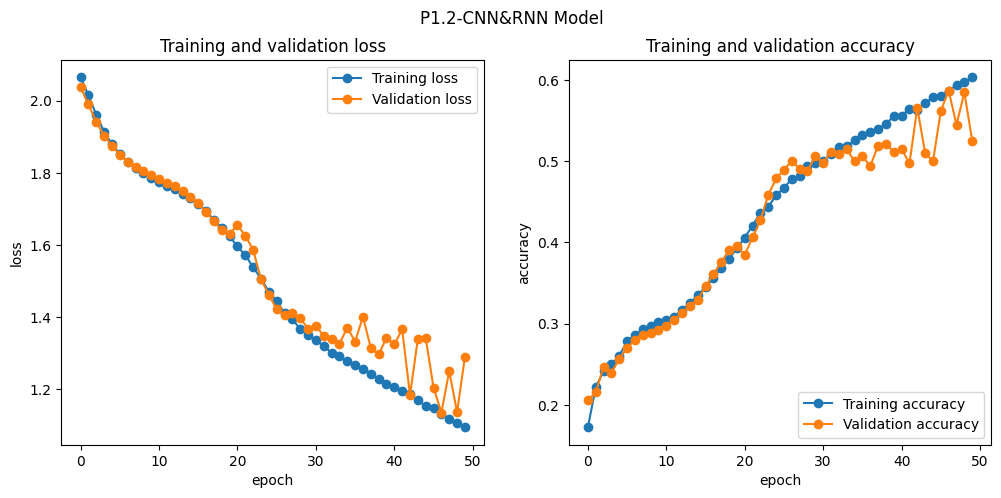

In [ ]:
#plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['loss'],'-o', label='Training loss')
ax1.plot(history.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history.history['acc'],'-o', label='Training accuracy')
ax2.plot(history.history['val_acc'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('P1.2-CNN&RNN Model')



In [ ]:
# evaluate test accuracy
results = model.evaluate(val_dataset_batch)
print('Validation Loss:', results[0])
print('Validation Accuracy:', results[1])

19/19 [==============================] - 0s 12ms/step - loss: 1.2885 - acc: 0.5250
Validation Loss: 1.2885037660598755
Validation Accuracy: 0.5249999761581421


## P2-Achieving higher accuracy

In [40]:
# In order to achieve the accuracy, i used the VGG-CNN network to train the model by building the block and achieve the accuracy
# Customisation from VGG16
# Set four blocks, and for each block it ends with the max pooling layer, faltten it and add three more dense layers, then finally add the output layer.
model = tf.keras.Sequential()
# VGG blocks
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(80,80,1))) 
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(80,80,1))) 
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
#model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
#model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset_batch, epochs=50, validation_data=val_dataset_batch)


Epoch 1/50
75/75 [==============================] - 96s 188ms/step - loss: 1.8986 - accuracy: 0.2382 - val_loss: 1.6274 - val_accuracy: 0.3725
Epoch 2/50
75/75 [==============================] - 14s 190ms/step - loss: 1.2174 - accuracy: 0.5482 - val_loss: 0.9787 - val_accuracy: 0.6346
Epoch 3/50
75/75 [==============================] - 15s 196ms/step - loss: 0.8774 - accuracy: 0.6743 - val_loss: 0.7797 - val_accuracy: 0.7088
Epoch 4/50
75/75 [==============================] - 15s 193ms/step - loss: 0.6985 - accuracy: 0.7459 - val_loss: 0.7305 - val_accuracy: 0.7262
Epoch 5/50
75/75 [==============================] - 14s 189ms/step - loss: 0.5551 - accuracy: 0.7974 - val_loss: 0.7069 - val_accuracy: 0.7529
Epoch 6/50
75/75 [==============================] - 14s 187ms/step - loss: 0.4513 - accuracy: 0.8338 - val_loss: 0.5189 - val_accuracy: 0.8142
Epoch 7/50
75/75 [==============================] - 14s 190ms/step - loss: 0.3871 - accuracy: 0.8593 - val_loss: 0.4858 - val_accuracy: 0.8288

Text(0.5, 0.98, 'P1.2-CNN&RNN Model')

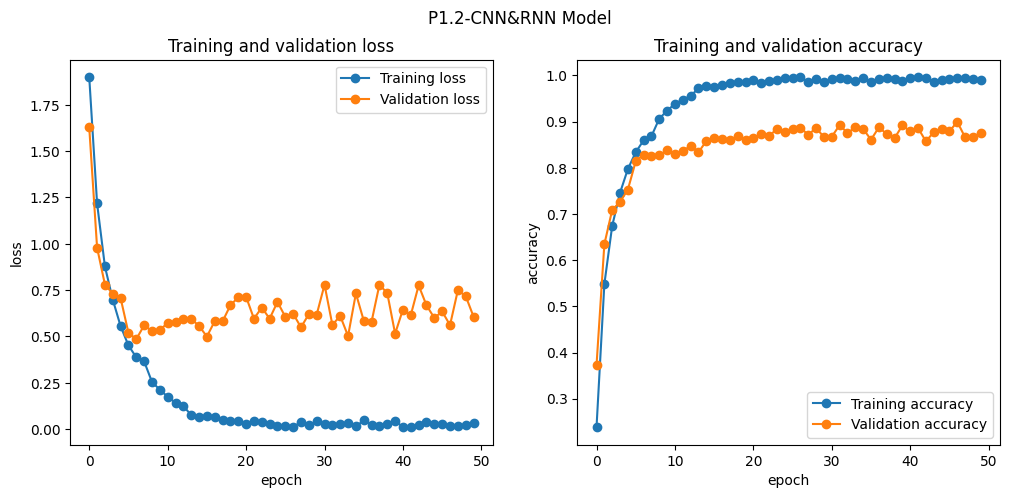

In [41]:
#plot the result
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['loss'],'-o', label='Training loss')
ax1.plot(history.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history.history['accuracy'],'-o', label='Training accuracy')
ax2.plot(history.history['val_accuracy'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('P1.2-CNN&RNN Model')

In [42]:
# evaluate test accuracy
results = model.evaluate(val_dataset_batch)
print('Validation Loss:', results[0])
print('Validation Accuracy:', results[1])

19/19 [==============================] - 1s 53ms/step - loss: 0.6067 - accuracy: 0.8758
Validation Loss: 0.6067357063293457
Validation Accuracy: 0.8758333325386047


#### there are several reasons why I chose VGG as the improved neural network
1. simplicity of the architecture The layers in VGG are quite similar and easy to understand. 
2. Proven to be effective already. VGG was used in various different image recognization cases, which is proofed to have the rubost structure and high accuracy. 
3. Previously, I haved tried to add another parallel layers based on P1.1, change the optimizer, learning rate, etc. But i was getting stuck in 79% accuracy. But when i tried the VGG, it achieved 85% accuracy, so I decided to use that